In [1]:
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
from scipy import signal 

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from utility_programs.read_routines.GITM import auto_read as auto_read_gitm
from  utility_programs.read_routines.SAMI import auto_read as auto_read_sami
import utility_programs.filters as filters

import gc

from tqdm.auto import tqdm
import glob, os

import importlib

/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [2]:

t_11 = datetime(2011,11,20)
t_05 = datetime(2011, 5,20)

t_start0 = timedelta(days=1, hours = 9) # Delta from t_start
t_end0 = timedelta(days=1, hours=19)     #  in hours



dir11 = '/glade/u/home/abukowski/scratch/simstorm-20111121/postprocessed/'
dir05 = '/glade/u/home/abukowski/scratch/simstorm-20110521/postprocessed/'

In [3]:
afewtimes = [10,20,30,40,50,60]
afewtimes2 = [10,20,30,40,50,60,70,80]

alts = [225, 660, 850]

lons = np.linspace(0,360,7)[:-1]

gitmcol  = ['Rho']
samicol  = ['edens']

In [4]:
gitmcol + samicol

['Rho', 'edens']

## Background:

In [5]:
# Just want to make an example time_list. 
# Can & should be changed in the future.


times = []
t = t_05
max_dtime = t_05 + timedelta(days=7)
while t < max_dtime:
    times.append(t)
    t+=timedelta(minutes=5)
times = np.array(times)

start_idx = np.argmin(np.abs(times - (t_05 + t_start0)))
end_idx = np.argmin(np.abs(times - (t_05 + t_end0)))

In [6]:
start_idx, end_idx

(396, 516)

In [41]:
def get_fit(array, lowcut=80, highcut=40):
    
    return xr.apply_ufunc(filters.make_fits, array.load(), lowcut, highcut)

def get_diffs(array):
    return 100*(array - get_fit(array))/array

In [8]:
def panel_of_maps(da,
                  times,
                  vlims,
                 out_name=None):
    
    p = da.isel(time=times).plot(x="lon", y="lat", col="time",
                                     transform=ccrs.PlateCarree(),
                                     subplot_kws={"projection": ccrs.PlateCarree(),
                                                 },
                                     col_wrap=2, vmin=-vlims, vmax = vlims, cmap = 'bwr',
                                    aa=True, )

    for ax in p.axs.flatten():
        ax.coastlines(alpha=0.6)
        ax.gridlines(color='black', alpha=0.5, linestyle='--')
    

        
    p.fig.suptitle('alt = %i km' % da.alt.mean())
    
    
    if out_name is None:
        plt.show()
        plt.close('all')
    else:
        plt.savefig(out_name)
        plt.close('all')

    
    
    
    
def panel_of_keos(da,
                  lons,
                  vlims,
                 out_name=None):
    
    p = da.sel(lon=lons, method='nearest').plot(x="time", y="lat", col="lon",
                                     col_wrap=2, vmin=-vlims, vmax = vlims, cmap = 'bwr',
                                    aa=True)


    p.fig.suptitle('alt = %i km' % da.alt.mean())
    # plt.tight_layout()

    if out_name is None:
        plt.show()
        plt.close('all')
    else:
        plt.savefig(out_name)
        plt.close('all')
    
    
    
def panel_of_lat_keos(da,
                  lats,
                  vlims,
                     out_name=None):
    
    p = da.sel(lat=lats, method='nearest').plot(x="time", y="lon", col="lat",
                                     col_wrap=2, vmin=-vlims, vmax = vlims, cmap = 'bwr',
                                    aa=True)


    p.fig.suptitle('alt = %i km' % da.alt.mean())
    # plt.tight_layout()
    if out_name is None:
        plt.show()
        plt.close('all')
    else:
        plt.savefig(out_name)
        plt.close('all')


## Read in all data

In [9]:
may = {}
nov = {}


if 'pbar' in locals():
    pbar.close();
pbar=tqdm(total=2*len(os.listdir(dir05) + os.listdir(dir11)), desc='reading in data')


# May files
for path in os.listdir(dir05):
    may[path.lower() + '-sami'] = auto_read_sami(dir05+path, cols=samicol,
                                                 start_idx=start_idx, end_idx=end_idx, use_dask=False)
    pbar.update()
    if 'Q' not in path:
        may[path.lower() + '-gitm'] = auto_read_gitm(dir05+path, cols=gitmcol,
                                                 start_idx=start_idx, end_idx=end_idx, use_dask=False)
    pbar.update()
    
# November files
for path in os.listdir(dir11):
    nov[path.lower() + '-sami'] = auto_read_sami(dir11+path, cols=samicol,
                                                 start_idx=start_idx, end_idx=end_idx, use_dask=False)
    pbar.update()
    nov[path.lower() + '-gitm'] = auto_read_gitm(dir11+path, cols=gitmcol,
                                                 start_idx=start_idx, end_idx=end_idx, use_dask=False)
    pbar.update()
    
    
pbar.close()

reading in data:  25%|██▌       | 5/20 [03:46<09:01, 36.10s/it]

KeyboardInterrupt: 

In [ ]:
may.keys(), nov.keys()

## Panel plot of all maps, at several times:

In [ ]:
'alts = ', alts

In [ ]:
out_name = None

for fname in may.keys():


    
    for a in alts:
        # """ Comment this line to show plots and only run one iteration:"""
    
        out_name = '/glade/u/home/abukowski/plots/nbplots/panelmaps/may-'+str(int(a))+'-'+fname
        
        if 'sami' in fname:
            for var in may[fname].data_vars:
                if out_name is not None:
                    out_name += var
                    
                panel_of_maps(get_diffs(may[fname][var].sel(alt=a, method='nearest')),
                      afewtimes2, 2, out_name)
                

                
        if 'gitm' in fname and a < 700:
            for var in nov[fname].data_vars:
                if out_name is not None:
                    out_name += var
                    
                panel_of_maps(get_diffs(may[fname][var].sel(alt=a, method='nearest')),
                      afewtimes2, 2, out_name)

            

            
    # if out_name is None:
    #     break

In [ ]:
out_name = None

for fname in nov.keys():
    
    
    for a in alts:
        # """ Comment this line to show plots and only run one iteration:"""
    
        out_name = '/glade/u/home/abukowski/plots/nbplots/panelmaps/nov-'+str(int(a))+'-'+fname

        if 'sami' in fname:
            for var in may[fname].data_vars:
                if out_name is not None:
                    out_name += var
                    
                panel_of_maps(get_diffs(nov[fname][var].sel(alt=a, method='nearest')),
                      afewtimes2, 2, out_name)
        if 'gitm' in fname and a < 700:
            for var in nov[fname].data_vars:
                if out_name is not None:
                    out_name += var
                    
                panel_of_maps(get_diffs(nov[fname][var].sel(alt=a, method='nearest')),
                      afewtimes2, 2, out_name)
            
    # if out_name is None:
    #     break

## Plot a single point throughout time

In [ ]:
#             lon ,  lat,  alt
lonlatalt = [
    [0,      50, 550],
    [180+50, 40, 150],
    [180,    35, 250],
    [60,     40, 650],
    [300,   -20, 450],
    [300, 20, 450],
    [300, 40, 500],
    [300, -40,500],
    [320, 45,200],
    [320,45, 400],
    [320, 45, 600]
    [320, -45,200],
    [320,-45, 400],
    [320, -45, 600]]


plottypes = [
    [['full', 'half'],],
    
    [['bz8-bypos', 'bz8-byneg'],
     ['bz15-bypos', 'bz15-byneg'],
     ['bz17']]
        ]


out_name = None


iterator = 0 # for saving. easier this way.


maykeys = str(list(may.keys()))
novkeys = str(list(nov.keys()))


for plotvar in (gitmcol + samicol):
    if plotvar in samicol:
        model = 'sami'
    elif plotvar in gitmcol:
        model = 'gitm'
    else:
        raise ValueError(plotvar, 'not found in model outputs')
        
    for numplot in plottypes:
        
        inmay = all([i in maykeys for i in sum(numplot, [])])        
        innov = all([i in novkeys for i in sum(numplot, [])])

        
        nrows = len(numplot)
        if inmay and innov:
            nrows += 1
            skipdouble = True
            
        fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(11, 1+nrows*4),)
        
        out_name = '/glade/u/home/abukowski/plots/nbplots/single_pt/' + str(int(iterator)).rjust(3, '0')
        
        row=0
        for lines in numplot:
            
            for line in lines:
                if inmay:
                    if inmay and innov:
                        row = 0
                    # print('may, line = ', line, ' row = ', row)           
                    
                    get_diffs(may[line+'-'+model][plotvar].sel(
                        lon=ilon, alt=ialt, lat=ilat, method='nearest')).plot(
                        ax=axs[row, 0], label=line)

                    get_fit(may[line+'-'+model][plotvar].sel(
                        lon=ilon, alt=ialt, lat=ilat, method='nearest')).plot(
                        ax=axs[row, 1], label=line+' (fit)')
                    may[line+'-'+model][plotvar].sel(
                        lon=ilon, alt=ialt, lat=ilat, method='nearest').plot(
                        ax=axs[row, 1], label=line+' (raw)')
                    
                if innov:
                    if inmay and innov:
                        row = 1
                    # print('nov, line = ', line, ' row = ', row)
                    
                    get_diffs(nov[line+'-'+model][plotvar].sel(
                        lon=ilon, alt=ialt, lat=ilat, method='nearest')).plot(
                        ax=axs[row, 0], label=line)

                    get_fit(nov[line+'-'+model][plotvar].sel(
                        lon=ilon, alt=ialt, lat=ilat, method='nearest')).plot(
                        ax=axs[row, 1], label=line+' (fit)')
                    nov[line+'-'+model][plotvar].sel(
                        lon=ilon, alt=ialt, lat=ilat, method='nearest').plot(
                        ax=axs[row, 1], label=line+' (raw)')
            
            row += 1
            
        for ax in axs.flatten():
            ax.legend()        
        fig.tight_layout()
        
        
        if out_name is None:
            plt.show()
            plt.close('all')
        else:
            plt.savefig(out_name)
            plt.close('all')

        iterator += 1

                
                
                
        
    # break



## Longitude Keograms

In [ ]:
lons

In [ ]:
out_name = None

for fname in may.keys():
    


    for a in alts:
        # """ Comment this line to show plots and only run one iteration:"""

        out_name = '/glade/u/home/abukowski/plots/nbplots/panelkeos/may-alt-%i-%s' %(int(a), fname)
        
        if 'sami' in fname:
            for var in may[fname].data_vars:
                if out_name is not None:
                    out_name += var
                                
                panel_of_keos(get_diffs(may[fname][var].sel(alt=a, method='nearest')),
                      lons, 2, out_name)
        if 'gitm' in fname and a < 700:
            for var in nov[fname].data_vars:
                if out_name is not None:
                    out_name += var
                                
                panel_of_keos(get_diffs(may[fname][var].sel(alt=a, method='nearest')),
                      lons, 2, out_name)


    # if out_name is None:
    #     break

In [10]:
out_name = None

for fname in nov.keys():

    if out_name is None:
        print(fname)
    
    for a in alts:
        # """ Comment this line to show plots and only run one iteration:"""

        out_name = '/glade/u/home/abukowski/plots/nbplots/panelkeos/nov-alt-%i-%s' %(int(a), fname)
        if 'sami' in fname:
            for var in may[fname].data_vars:
                if out_name is not None:
                    out_name += var
                                
                panel_of_keos(get_diffs(nov[fname][var].sel(alt=a, method='nearest')),
                      lons, 2, out_name)
        if 'gitm' in fname and a < 700:
            for var in nov[fname].data_vars:
                if out_name is not None:
                    out_name += var
                                
                panel_of_keos(get_diffs(nov[fname][var].sel(alt=a, method='nearest')),
                      lons, 2, out_name)

    # if out_name is None:
    #     break


## Latitude Keograms

In [ ]:
lats = np.linspace(-45,45, 6); lats

In [ ]:
out_name = None

for fname in may.keys():

        
    for a in alts:
        # """ Comment this line to show plots and only run one iteration:"""

        out_name = '/glade/u/home/abukowski/plots/nbplots/panel-lat-keos/may-alt-%i--%s' %(int(a), fname)
        
        if 'sami' in fname:
            panel_of_lat_keos(get_diffs(may[fname][var].sel(alt=a, method='nearest')),
                  lats, 2, out_name)
        if 'gitm' in fname and a < 700:
            panel_of_lat_keos(get_diffs(may[fname][var].sel(alt=a, method='nearest')),
                  lats, 2, out_name)


    # if out_name is None:
    #     break

In [ ]:
out_name = None

for fname in nov.keys():

    
    for a in alts:
        # """ Comment this line to show plots and only run one iteration:"""

        out_name = '/glade/u/home/abukowski/plots/nbplots/panel-lat-keos/nov-alt-%i-%s' %(int(a), fname)
        if 'sami' in fname:
            panel_of_lat_keos(get_diffs(nov[fname][var].sel(alt=a, method='nearest')),
                  lats, 2, out_name)
        if 'gitm' in fname and a < 700:
            panel_of_lat_keos(get_diffs(nov[fname][var].sel(alt=a, method='nearest')),
                  lats, 2, out_name)

    # if out_name is None:
    #     break


## Other stuff

In [12]:
get_diffs(nov['full-gitm'].Rho.sel(lon=2,alt=650, method='nearest')).plot()

NameError: name 'nov' is not defined

In [13]:
get_diffs(nov['full-gitm'].Rho.sel(lon=300, method='nearest')).isel(time=45).plot(x='lat', y='alt')

NameError: name 'nov' is not defined

In [41]:
del dss

In [9]:
gc.collect()

110

In [182]:
s = datetime.now()

# dss = []
fs = np.sort(glob.glob(dir05+"Half/SAMI*"))[start_idx:end_idx]

# ds = xr.open_mfdataset(fs,  combine='nested', concat_dim='time', engine='h5netcdf')
ds = xr.open_mfdataset([i.replace("Half", 'Full') for i in fs],  combine='nested', concat_dim='time', engine='h5netcdf')

print(datetime.now()-s)

0:00:52.808880


In [183]:
ds

<xarray.Dataset>
Dimensions:         (time: 120, alt: 40, lat: 180, lon: 90)
Coordinates:
  * time            (time) datetime64[ns] 2011-05-21T09:00:00 ... 2011-05-21T...
  * alt             (alt) float64 200.0 250.0 300.0 ... 2.1e+03 2.15e+03
  * lat             (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * lon             (lon) float64 0.0 4.0 8.0 12.0 ... 344.0 348.0 352.0 356.0
Data variables: (12/25)
    edens           (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    h+dens          (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    o+dens          (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    n+odens         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    o2+dens         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    he+dens         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    ...              ...
    h+vel_parallel  (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    o+vel_parallel  (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    mer_exb         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    zon_exb         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    zon_neut        (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    mer_neut        (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>

In [319]:
ds2 = xr.open_mfdataset(fs, engine = 'h5netcdf', combine='nested', concat_dim='time')

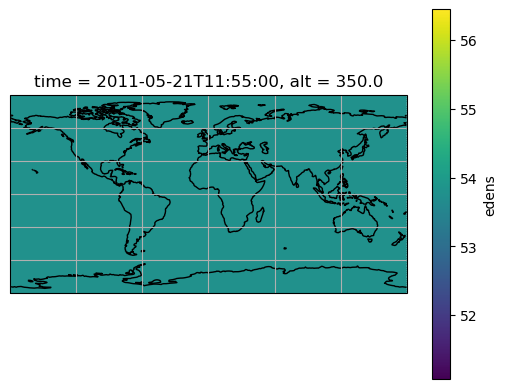

In [323]:
p=ds2.edens.sel(alt=350).isel(time=35).plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
p.axes.gridlines()
p.axes.coastlines()
                                          

In [189]:
ds.lat, ds.lon, ds.alt

(<xarray.DataArray 'lat' (lat: 180)>
 array([-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80., -79.,
        -78., -77., -76., -75., -74., -73., -72., -71., -70., -69., -68., -67.,
        -66., -65., -64., -63., -62., -61., -60., -59., -58., -57., -56., -55.,
        -54., -53., -52., -51., -50., -49., -48., -47., -46., -45., -44., -43.,
        -42., -41., -40., -39., -38., -37., -36., -35., -34., -33., -32., -31.,
        -30., -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19.,
        -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
         -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,
          6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
         18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
         30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
         42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
   

<xarray.DataArray 'edens' (lat: 180, lon: 90)>
dask.array<getitem, shape=(180, 90), dtype=float64, chunksize=(180, 90), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2011-05-21T12:45:00
    alt      float64 400.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float64 0.0 4.0 8.0 12.0 16.0 ... 344.0 348.0 352.0 356.0

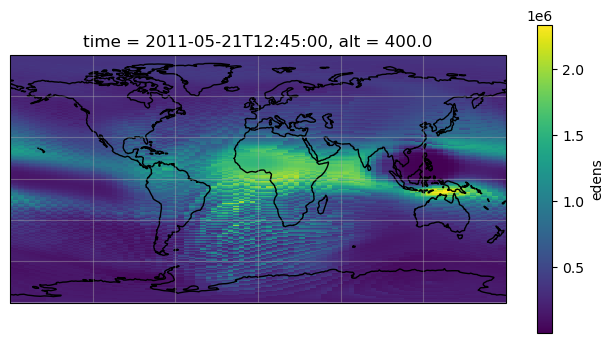

In [249]:
plt.figure(figsize=(8,4))
p=ds.isel(time=45).sel(alt=400, method='nearest').edens.plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
p.axes.coastlines()
p.axes.gridlines(alpha=0.4)
ds.isel(time=45).sel(alt=400).edens

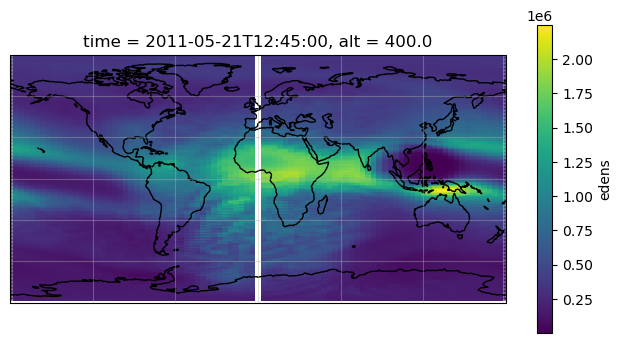

In [391]:
plt.figure(figsize=(8,4))
p=ds.isel(time=45).sel(alt=400, method='nearest').edens.rolling(lat=3, lon=2).mean().plot(transform=ccrs.PlateCarree(),
                                                                                   subplot_kws={"projection": ccrs.PlateCarree()},
                                                                                   aa=True)
p.axes.coastlines()
p.axes.gridlines(alpha=0.4);
# ds.isel(time=45).sel(alt=400).edens

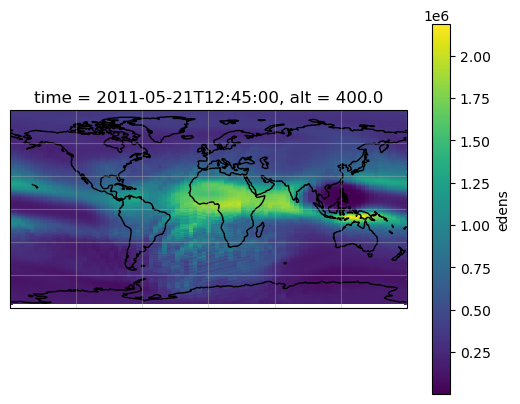

In [383]:

p=ds.isel(time=45).sel(alt=400, method='nearest').edens\
    .rolling(lat=5, ).mean()\
    .plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
p.axes.coastlines()
p.axes.gridlines(alpha=0.4);

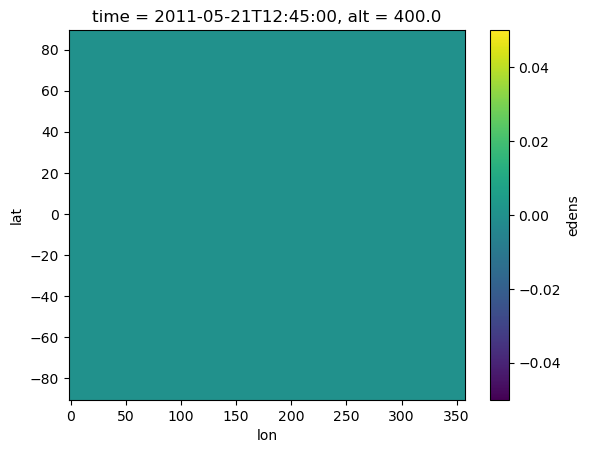

In [379]:
ds.edens.sel(alt=400).isel(time=45).isnull().plot()

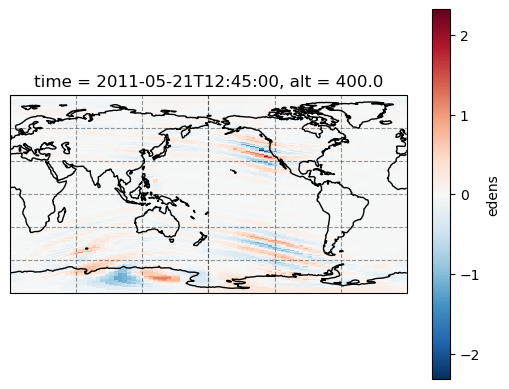

In [284]:
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))

get_diffs(ds.sel(alt=400, method='nearest').edens).isel(time=45).plot(transform=ccrs.PlateCarree(),ax=ax,aa=True)
ax.coastlines()
ax.gridlines(linestyle='--', color='black', alpha=0.4);

In [60]:
alts = np.arange(250,1001, 100)

In [61]:
alts

array([250, 350, 450, 550, 650, 750, 850, 950])

In [304]:
ds.data_vars

Data variables:
    edens           (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    h+dens          (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    o+dens          (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    n+odens         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    o2+dens         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    he+dens         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    n2+dens         (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    n+dens          (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    hdens           (time, lat, lon, alt) float64 dask.array<chunksize=(1, 180, 90, 40), meta=np.ndarray>
    odens           (time, lat

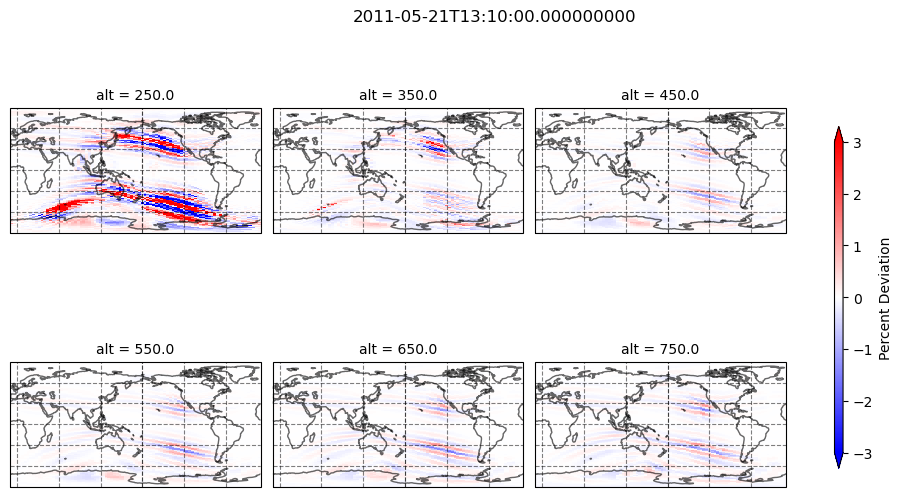

In [317]:

p=get_diffs(ds['edens'].sel(alt=alts[:-2])).isel(time=50).plot(x='lon', col='alt', col_wrap=3, vmin=-3, vmax=3,cmap='bwr',
                                                       transform=ccrs.PlateCarree(),robust=False,
                                                       cbar_kwargs={'orientation':'vertical',
                                                                    'shrink':0.6, 'aspect':40,
                                                                    'label':'Percent Deviation'},
                                                       subplot_kws={"projection": ccrs.PlateCarree(central_longitude=170),},)

for ax in p.axs.flatten():
    ax.coastlines(alpha=0.6)
    ax.gridlines(color='black', alpha=0.5, linestyle='--')
    
# p.cbar.set_label('Electron Density % over Background')
p.fig.suptitle(ds.isel(time=50).time.values)
    
plt.show()